## Logistic Regression: Multi-Class (Multinomial) -- Full MNIST digits classification example

This post will be an implementation and example of what is commonly called ["Multinomial Logistic Regression"](https://en.wikipedia.org/wiki/Multinomial_logistic_regression). The particular method I will look at is "one-vs-all" or "one-vs-rest".

> **<rant-on>** **What's in a name?** "*A rose by any other name would smell as sweet*". In my opinion calling this "Multinomial Logistic Regression" stinks! A multinomial is a specific mathematical thing and I already used "multinomial term expansion of feature sets". I really feel that a more descriptive name would be "Multi-Class". ... but Multinomial Logistic Regression is the name that is commonly used.**<rant-off>**  

This post is heavy on Python code and job runs. It includes the implementation code from the [previous post](https://www.pugetsystems.com/labs/hpc/Machine-Learning-and-Data-Science-Logistic-Regression-Examples-1-1003/) with additional code to generalize that to multi-class. The usage example will be image classification of hand written digits (0-9) using the MNIST dataset. 

I've done four earlier posts on Logistic Regression that give a pretty thorough explanation of Logistic Regress and cover theory and insight for what I'm looking at in this post, [Logistic Regression Theory](https://www.pugetsystems.com/labs/hpc/Machine-Learning-and-Data-Science-Logistic-Regression-Theory-988/) and [Logistic and Linear Regression Regularization](https://www.pugetsystems.com/labs/hpc/Machine-Learning-and-Data-Science-Logistic-and-Linear-Regression-Regularization-994/), [Logistic Regression Implementation](https://www.pugetsystems.com/labs/hpc/Machine-Learning-and-Data-Science-Logistic-Regression-Implementation-996/), [Logistic Regression: Examples 1 -- 2D data fit with multinomial model and 0 1 digits classification on MNIST dataset](https://www.pugetsystems.com/labs/hpc/Machine-Learning-and-Data-Science-Logistic-Regression-Examples-1-1003/).

This will be a "calculator" style implementation using Python in this Jupyter notebook. Everything needed to "tinker" with the method is contained in this notebook except the MNIST dataset. I pulled the [MNIST training set from **Kaggle**](https://www.kaggle.com/c/digit-recognizer/data). For information on the dataset itself see [Yann Lecun's site http://yann.lecun.com/exdb/mnist/index.html](http://yann.lecun.com/exdb/mnist/index.html). To use this notebook for your own experimentation you would need to download that dataset. 

>This posts along with all of the others in this series were converted to html from Jupyter notebooks. The notebooks are available at [https://github.com/dbkinghorn/blog-jupyter-notebooks](https://github.com/dbkinghorn/blog-jupyter-notebooks)
<hr />


## Understanding Multi-Class (Multinomial) Logistic Regression

You can think of logistic regression as if the logistic (sigmoid) function is a single "neuron" that returns the probability that some input sample is the "thing" that the neuron was trained to recognize. It is a binary classifier. It just gives the probability that the input it is looking at is the **ONE thing** that it was trained to recognize. To generalize this to several "things" (classes) we can create a collection of these binary "neurons" with one for each class of the things the we want to distinguish. You could think of that as a single layer network of these sigmoid neurons. 

To classify the 10 digits 0-9 there would be 10 of these sigmoid neurons in a single layer network. Like this,

![fig1](./logistic-net09-tikz.png)

The $f_i$ are the features i.e. pixels in an image, $h_i$ are the 10 individual digit models and MAX(P) is the result with the highest probability.

That is basically what we are going to do. In general the steps are,

- Create a 0,1 vector $y_k$ for each class $k$. Each $y_k$ will have a 1 matching the position of all samples in the training set that match that class and 0 otherwise. (I will put them in a matrix $Y$ where the $k^{th}$ column of $Y$ is $y_k$)
- Do an optimization loop over all $k$ classes finding an optimal parameter vector $a_k$ to define $k$ models $h_k$
- To test i.e. classify, an input evaluate it with each $h_k$ to get a probability that it is in class $k$.
- Pick the class with the highest probability as the "answer".

Specifically for the MNIST digits dataset being used; 
- There will be $k=10$ classes with labels {0,1,2,3,4,5,6,7,8,9}.
    - For a set with $m$ samples $Y_{set}$ will be an $(m \times 10)$ matrix of 0's and 1's corresponding to samples in each class. For example the first column of $Y$ will have a 1 in each row that is a sample image of a "0". ... The tenth column of $Y$ will have a 1 in each row that is a sample of a "9".        
- The full data set has 42000 samples which will be divided into 
   - 29400 training-set samples,
   - 6300 validation-set samples,
   - 6300 test-set samples. 
- The digit images in the MNIST dataset have 28 x 28 pixels. These pixels together with the bias term is the number of features. That means that each sample feature vector will have 784 + 1 = 785 features that we will need to find 785 parameters for.        
- The optimization loop will be over the 10 classes and will produce a matrix $A$ of optimized parameters by minimizing a cost function for each for the 10 classes. Each column of the 10 columns $A$ will be a model parameter vector corresponding to each of the 10 classes (0-9).
- To test or use the resulting model the input sample will be evaluated for each of the 10 "class models" and sorted by highest probability. The result with the highest probability is the prediction from the model.

Simple! Lets do it.
<hr />


## Core Logistic Regression Functions (Python Code)
This section is the base code for, logistic regression with regularization, that was worked up in the previous posts. You can skip over this section if you have seen the code in the last post and just refer back to it if you need to see how some function was defined.


In [1]:
import pandas as pd  # data handeling
import numpy as np   # numerical computing
from scipy.optimize import minimize  # optimization code
import matplotlib.pyplot as plt  # plotting
import seaborn as sns  
%matplotlib inline
sns.set()
import itertools  # combinatorics functions for multinomial code

In [2]:
#
# Main Logistic Regression Equations
#
def g(z) :  # sigmoid function
    return 1.0/(1.0 + np.exp(-z))

def h_logistic(X,a) : # Model function
    return g(np.dot(X,a))

def J(X,a,y) : # Cost Function 
    m = y.size
    return -(np.sum(np.log(h_logistic(X,a))) + np.dot((y-1).T,(np.dot(X,a))))/m

def J_reg(X,a,y,reg_lambda) : # Cost Function with Regularization
    m = y.size
    return J(X,a,y) + reg_lambda/(2.0*m) * np.dot(a[1:],a[1:])

def gradJ(X,a,y) : # Gradient of Cost Function
    m = y.size
    return (np.dot(X.T,(h_logistic(X,a) - y)))/m

def gradJ_reg(X,a,y,reg_lambda) : # Gradient of Cost Function with Regularization
    m = y.size
    return gradJ(X,a,y) + reg_lambda/(2.0*m) * np.concatenate(([0], a[1:])).T

In [3]:
#
# Some model checking functions
#
def to_0_1(h_prob) : # convert probabilites to true (1) or false (0) at cut-off 0.5
    return np.where(h_prob >= 0.5, 1, 0)

def model_accuracy(h,y) : # Overall accuracy of model
    return np.sum(h==y)/y.size * 100 

def model_accuracy_pos(h,y) : # Accuracy on positive cases
    return np.sum(y[h==1] == 1)/y[y==1].size * 100
    
def model_accuracy_neg(h,y) : # Accuracy on negative cases
    return np.sum(y[h==0] == 0)/y[y==0].size * 100
    
def false_pos(h,y) : # Number of false positives
    return np.sum((y==0) & (h==1))

def false_neg(h,y) : # Number of false negatives
    return np.sum((y==1) & (h==0))

def true_pos(h,y) : # Number of true positives
    return np.sum((y==1) & (h==1))

def true_neg(h,y) : # Number of true negatives
    return np.sum((y==0) & (h==0))
    
def model_precision(h,y) : # Precision = TP/(TP+FP)
    return true_pos(h,y)/(true_pos(h,y) + false_pos(h,y))

def model_recall(h,y) : # Recall = TP/(TP+FN)
    return true_pos(h,y)/(true_pos(h,y) + false_neg(h,y))

def print_model_quality(title, h, y) : # Print the results of the functions above
    print( '\n# \n# {} \n#'.format(title) )
    print( 'Total number of data points   = {}'.format(y.size))
    print( 'Number of Positive values(1s) = {}'.format(y[y==1].size))
    print( 'Number of Negative values(0s) = {}'.format(y[y==0].size))
    print( '\nNumber of True Positives = {}'.format(true_pos(h,y)) )
    print( 'Number of False Positives = {}'.format(false_pos(h,y)) )
    print( '\nNumber of True Negatives = {}'.format(true_neg(h,y)) )
    print( 'Number of False Negatives = {}'.format(false_neg(h,y)) )
    print( '\nModel Accuracy = {:.2f}%'.format( model_accuracy(h,y) ) )
    print( 'Model Accuracy Positive Cases = {:.2f}%'.format( model_accuracy_pos(h,y) ) )
    print( 'Model Accuracy Negative Cases = {:.2f}%'.format( model_accuracy_neg(h,y) ) )
    print( '\nModel Precision = {}'.format(model_precision(h,y)) )
    print( '\nModel Recall = {}'.format(model_recall(h,y)) )

In [4]:
def multinomial_partitions(n, k):
    """returns an array of length k sequences of integer partitions of n"""
    nparts = itertools.combinations(range(1, n+k), k-1)
    tmp = [(0,) + p + (n+k,) for p  in nparts]
    sequences =  np.diff(tmp) - 1
    return sequences[::-1] # reverse the order

def make_multinomial_features(fvecs,order=[1,2]) :
    '''Make multinomial feature matrix
       fvecs is a matrix of feature vectors (columns)
       "order" is a set of multinomial degrees to create 
       default is [1,2] meaning for example: given f1, f2 in fvecs
       return a matrix made up of a [1's column, f1,f2,f1**2,f1*f2,f2**2]   '''
    Xtmp = np.ones_like(fvecs[:,0])
    for ord in order :
        if ord==1 :
            fstmp = fvecs
        else :
            pwrs = multinomial_partitions(ord,fvecs.shape[1])
            fstmp = np.column_stack( ( np.prod(fvecs**pwrs[i,:], axis=1) for i in range(pwrs.shape[0]) ))

        Xtmp = np.column_stack((Xtmp,fstmp))
    return Xtmp

def mean_normalize(X):
    '''apply mean normalization to each column of the matrix X'''
    X_mean=X.mean(axis=0)
    X_std=X.std(axis=0)
    return (X-X_mean)/X_std

def apply_normalizer(X,X_mean,X_std) :
    return (X-X_mean)/X_std

<hr />
## Data setup for the 10 digit classes

The data is the same that was used in the last post but this time I will use all of the 0-9 images. There are 42000 total. Each image has 784 pixels and the first column is the label for what the image is. Let's read that in and look at the first 10 entries, then put that into a matrix called data_full_matrix. 


In [5]:
data_full = pd.read_csv("./data/kg-mnist/train.csv")
data_full.head(10)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
data_full_matrix=data_full.as_matrix()
print(data_full_matrix.shape)

(42000, 785)


You can show any of the images in that matrix with the following snipit of code. This would show the image in the 4th row (index 3) which is a hand written 4.

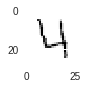

In [21]:
plt.figure(figsize=(1,1))
plt.imshow(data_full_matrix[3,1:].reshape((28,28)) )

<hr />
### Create matrix $Y$
There is a column in $Y$ for each of the digits 0-9. I print out the first 10 rows so you can see how it is laid out. The first column has a 1 at row 2,5 and 6 (1,4,5 is you count from 0), that means that those rows correspond to the number 0. There are 42000 rows in $Y$.


In [7]:
Y = np.zeros((data_full_matrix.shape[0],10))
for i in range(10) :
    Y[:,i] = np.where(data_full_matrix[:,0]==i, 1,0)

In [8]:
Y[0:10,:]

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])

<hr />
### Separate out the label column and remove columns that are all 0's
We got rid of 76 feature columns that were all 0's

In [9]:
y_labels, data_09 = data_full_matrix[:,0], data_full_matrix[:,1:]
print(data_09.shape)
data_09 = data_09[:,data_09.sum(axis=0)!=0]
print(data_09.shape)

(42000, 784)
(42000, 708)


<hr />
### Divide the dataset into sets for Training, Validation and Testing 
There will be 29400 images in the Training set and 6300 images in each of the Validation and Test sets. The matrix $Y$ is divided up the same way.

In [10]:
data_train_09,Y_train_09 = data_09[0:29400,:],     Y[0:29400,:]
data_val_09, Y_val_09    = data_09[29400:35700,:],  Y[29400:35700,:]
data_test_09, Y_test_09  = data_09[35700:,:],      Y[35700:,:]

In [11]:
y_labels_train = y_labels[0:29400]
y_labels_val = y_labels[29400:35700]
y_labels_test = y_labels[35700:]

In [12]:
print(data_train_09.shape,Y_train_09.shape)
print(data_val_09.shape, Y_val_09.shape)
print(data_test_09.shape, Y_test_09.shape)

(29400, 708) (29400, 10)
(6300, 708) (6300, 10)
(6300, 708) (6300, 10)


<hr />

### Mean normalize the data sets
Each of the data sets are normalized using the mean and standard deviation from the whole 42000 element data set. The make_multinomial_features functions is used here simply to add the column of 1's to the data for the bias term. 


In [14]:
X_mean = data_09.mean(axis=0)
X_std  = data_09.std(axis=0)
X_std[X_std==0]=1.0 # if there are any 0 values in X_std set them to 1

order = [1]

X_train = make_multinomial_features(data_train_09, order=order)
X_train[:,1:] = apply_normalizer(X_train[:,1:],X_mean,X_std)
Y_train = Y_train_09

X_val = make_multinomial_features(data_val_09, order=order)
X_val[:,1:] = apply_normalizer(X_val[:,1:],X_mean,X_std)
Y_val = Y_val_09

X_test = make_multinomial_features(data_test_09, order=order)
X_test[:,1:] = apply_normalizer(X_test[:,1:],X_mean,X_std)
Y_test = Y_test_09

<hr />
### Find optimal parameters for the 10 models
**This is the main training loop.** All 10 models are optimized using the columns of $Y$ and the training data set. Each model is fit to it's number (0-9) by evaluation it's cost function against all of the other numbers "the rest".

You can see that some of the models required many more iterations before convergence. There was also some numerical overflow present. I'm not too concerned about this since it is an artifact of the optimization run. The models converged OK and gave reasonably good set of parameters for each of the 10 models. It is possible to work on each model separately to try to get better fits and the regularization term could be adjusted per model. I did play with the optimization somewhat but wont worry about it too much since in teh next post I'll be doing an implementation of "Stochastic Gradient Descent" and will likely use this data again as an example. 


In [15]:
reg =300.0 # Regularization term
np.random.seed(42)
aguess = np.random.randn(X_train.shape[1]) # A random guess for the parameters 
A_opt = np.zeros((X_train.shape[1],10)) # The matrix of optimized parameters 
Res=[] # List to hold the full optimizitaion output of each model

for i in range(10):
    print('\nFitting {} against the rest\n'.format(i))
    def opt_J_reg(a) :
        return J(X_train,a,Y_train[:,i])
    def opt_gradJ_reg(a) :
        return gradJ_reg(X_train,a,Y_train[:,i],reg)
    
    res = minimize(opt_J_reg, aguess, method='CG', jac=opt_gradJ_reg, tol=1e-6, options={'disp': True})
    Res.append(res)
    A_opt[:,i] = res.x


Fitting 0 against the rest

         Current function value: 0.028295
         Iterations: 27
         Function evaluations: 586
         Gradient evaluations: 573

Fitting 1 against the rest



/home/kinghorn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/home/kinghorn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


         Current function value: 0.031864
         Iterations: 17
         Function evaluations: 230
         Gradient evaluations: 217

Fitting 2 against the rest

         Current function value: 0.070383
         Iterations: 45
         Function evaluations: 1182
         Gradient evaluations: 1168

Fitting 3 against the rest

         Current function value: 0.086118
         Iterations: 32
         Function evaluations: 330
         Gradient evaluations: 318

Fitting 4 against the rest

         Current function value: 0.052558
         Iterations: 20
         Function evaluations: 254
         Gradient evaluations: 240

Fitting 5 against the rest

         Current function value: 0.119611
         Iterations: 14
         Function evaluations: 127
         Gradient evaluations: 116

Fitting 6 against the rest

         Current function value: 0.045620
         Iterations: 21
         Function evaluations: 273
         Gradient evaluations: 261

Fitting 7 against the rest

        

<hr />
You can look at the fit quality of each model. The model for the digit 8 has the worst finial value for the cost function and it looks like it had many false negatives. I am using the Validation data set check the quality of fit.

In [22]:
num=8
a_opt = A_opt[:,num]
h_prob = h_logistic(X_val,a_opt)
h_predict = to_0_1(h_prob)
print_model_quality('Validation-data fit', h_predict, Y_val[:,num])


# 
# Validation-data fit 
#
Total number of data points   = 6300
Number of Positive values(1s) = 611
Number of Negative values(0s) = 5689

Number of True Positives = 341
Number of False Positives = 69

Number of True Negatives = 5620
Number of False Negatives = 270

Model Accuracy = 94.62%
Model Accuracy Positive Cases = 55.81%
Model Accuracy Negative Cases = 98.79%

Model Precision = 0.8317073170731707

Model Recall = 0.55810147299509


<hr />
The fit for the "0" model has a low cost function and the quality of fit looks much better than that for "8".

In [23]:
num=0
a_opt = A_opt[:,num]
h_prob = h_logistic(X_val,a_opt)
h_predict = to_0_1(h_prob)
print_model_quality('Validation-data fit', h_predict, Y_val[:,num])


# 
# Validation-data fit 
#
Total number of data points   = 6300
Number of Positive values(1s) = 618
Number of Negative values(0s) = 5682

Number of True Positives = 577
Number of False Positives = 44

Number of True Negatives = 5638
Number of False Negatives = 41

Model Accuracy = 98.65%
Model Accuracy Positive Cases = 93.37%
Model Accuracy Negative Cases = 99.23%

Model Precision = 0.92914653784219

Model Recall = 0.9336569579288025


<hr />
### Use the model to make predictions for untested number images

The following function will return the probabilities predicted by each of the models for some given input image. The probabilities are sorted with the most likely being listed first.


In [24]:
def predict(sample, sample_label):
    print('\nTest sample is : {}\n'.format(sample_label))
    probs = np.zeros((10,2))
    for num in range(10):
        a_opt = A_opt[:,num]
        probs[num,0] = num
        probs[num,1] = h_logistic(sample,a_opt)

    probs = probs[probs[:,1].argsort()[::-1]] # put the best guess at the top
    print('Model prediction probabilites\n')
    for i in range(10):
        print( "{} with probability = {:.3f}".format(int(probs[i,0]), probs[i,1]) )
        

<hr />
Following are a few random images picked from the test set.

The first image is of an "8". You can see that the model did not give a very high probability for "8" but it was higher than any of the other probabilities so it did give the correct answer!

In [25]:
samp = 23
samp_label = y_labels_test[samp]
sample = X_test[samp,:]
predict(sample, samp_label)


Test sample is : 8

Model prediction probabilites

8 with probability = 0.253
3 with probability = 0.097
9 with probability = 0.081
5 with probability = 0.000
2 with probability = 0.000
7 with probability = 0.000
4 with probability = 0.000
1 with probability = 0.000
6 with probability = 0.000
0 with probability = 0.000


In [18]:
samp = 147
samp_label = y_labels_test[samp]
sample = X_test[samp,:]
predict(sample,samp_label)


Test sample is : 2

Model prediction probabilites

2 with probability = 0.994
6 with probability = 0.016
3 with probability = 0.004
1 with probability = 0.000
9 with probability = 0.000
0 with probability = 0.000
5 with probability = 0.000
8 with probability = 0.000
4 with probability = 0.000
7 with probability = 0.000


In [27]:
samp = 6200
samp_label = y_labels_test[samp]
sample = X_test[samp,:]
predict(sample,samp_label)


Test sample is : 4

Model prediction probabilites

4 with probability = 0.977
2 with probability = 0.034
7 with probability = 0.022
9 with probability = 0.005
3 with probability = 0.002
6 with probability = 0.002
0 with probability = 0.002
8 with probability = 0.001
5 with probability = 0.001
1 with probability = 0.001


<hr />
### Checking how well the model did for each of the datasets
The next function will give a printout of the percentage of correct prediction in a dataset. We first look at the training and validation sets.

In [28]:
def print_num_correct(datasets):
    for dataset in datasets : 
        set_name, yl, Xd = dataset
        yls = yl.size
        probs = np.zeros((10,2))
        count = 0
        for samp in range(yls):
            for num in range(10):
                a_opt = A_opt[:,num]
                probs[num,0] = num
                probs[num,1] = h_logistic(Xd[samp,:],a_opt)

            probs = probs[probs[:,1].argsort()[::-1]]
            if probs[0,0] == yl[samp] :
                count +=1
        print('\n{}'.format(set_name))
        print("{} correct out of {} : {}% correct".format(count, yls, count/yls * 100)) 
        

In [29]:
datasets = [('Training Set:', y_labels_train, X_train),('Validation Set:',y_labels_val, X_val)]
print_num_correct(datasets)


Training Set:
26481 correct out of 29400 : 90.07142857142857% correct

Validation Set:
5590 correct out of 6300 : 88.73015873015872% correct


... and now the test set.

In [30]:
print_num_correct([('Test Set:', y_labels_test, X_test)])


Test Set:
5597 correct out of 6300 : 88.84126984126985% correct


<hr />

### Conclusion

That's not too bad for a simple method like Logistic Regression. It was fairly easy to implement and extend to the multi-class case. The results showing the number correct is fairly consistent across the different datasets and it looks like it has a prediction value of around 88%.

<hr />
In the next post I'll do an implementation of Stochastic Gradient Descent (SGD) which is commonly used in machine learning especially for training neural networks. I may be able to add multinomial features to the digits model using SGD for the optimization since it should work well with very large numbers of features. We'll see :-)
<hr />

#### Happy computing!  --dbk  
   